In [1]:
# RUNTIME = 'colab'
RUNTIME = 'local'

In [2]:
if RUNTIME == 'colab':
    %%capture
    !pip install polygon-api-client
    !pip install requests
    !pip install pandas
    !pip install tqdm
    !pip install mplfinance
    !pip install tensorflow
    !pip install numpy
    !pip install matplotlib
    !pip install scikit-learn
    !pip install fastparquet

In [3]:
import os
import calendar
from datetime import datetime, timedelta
from functools import partial

from polygon import RESTClient
import requests
import pandas as pd
from tqdm.notebook import tqdm
import mplfinance as mpf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [4]:
if RUNTIME == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

# 1. Load Data

In [5]:
def get(path, params={}):
    session = requests.Session()
    url = 'https://api.polygon.io' + path
    params['apiKey'] = os.environ['POLYGON_API_KEY']
    resp = session.request('GET', url, params=params)
    resp.raise_for_status()
    return resp.json()

In [6]:
def get_bars(from_date, to_date):
    if isinstance(from_date, datetime):
        from_date = datetime.strftime(from_date, '%Y-%m-%d')
    if isinstance(to_date, datetime):
        to_date = datetime.strftime(to_date, '%Y-%m-%d')
    return get('/v2/aggs/ticker/{}/range/{}/{}/{}/{}'.format('SBUX',
                                                             1,
                                                             'minute',
                                                             from_date,
                                                             to_date))['results']

In [7]:
class TradingDay:
    def __init__(self, date):
        if isinstance(date, str):
            self.start = datetime.strptime(date, '%Y-%m-%d')
        if isinstance(date, datetime):
            self.start = date
        self.end = self.start + timedelta(days=1)
        #self.weekday = calendar.day_name[self.start.weekday()]
        self.bars = pd.DataFrame(columns=['timestamp',
                                          'volume',
                                          'open',
                                          'close',
                                          'high',
                                          'low',
                                          'num_trades'])
        for bar in get_bars(self.start, self.end):
            self.bars = self.bars.append({
                'timestamp': bar['t'],
                'volume': bar['v'],
                'open': bar['o'],
                'close': bar['c'],
                'high': bar['h'],
                'low': bar['l'],
                'num_trades': bar.get('n', 0)
            }, ignore_index=True)
        
class TradingYear:
    def __init__(self, year):
        self.days = [
            TradingDay(
                datetime.strptime(
                    '{}-2019'.format(str(day)), '%j-%Y'
                )
            ) for day in tqdm(range(1,366))
        ]
   
    def get_bars(self):
        return pd.concat([day.bars for day in self.days])

If there is a data file, load it. If not, request data from the Polygon API and save it to a file.

In [8]:
if RUNTIME == 'local':
    DIR = '.data/2019_year_df.parquet.gzip'
elif RUNTIME == 'colab':
    DIR = '/content/drive/My Drive/pbc/2019_year_df.parquet.gzip'

try:
    year_df = pd.read_parquet(DIR)
except FileNotFoundError as e:
    year_df = TradingYear(2019).get_bars()
    year_df['timestamp'] = pd.to_datetime(year_df['timestamp'], unit='ms')
    year_df = year_df.set_index('timestamp')
    year_df.to_parquet(DIR, compression='gzip')

<AxesSubplot:xlabel='timestamp'>

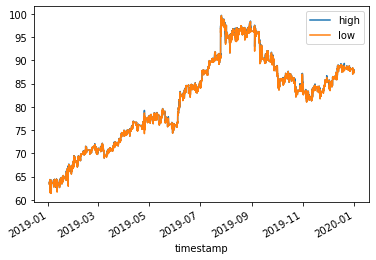

In [9]:
year_df[['high', 'low']].plot()

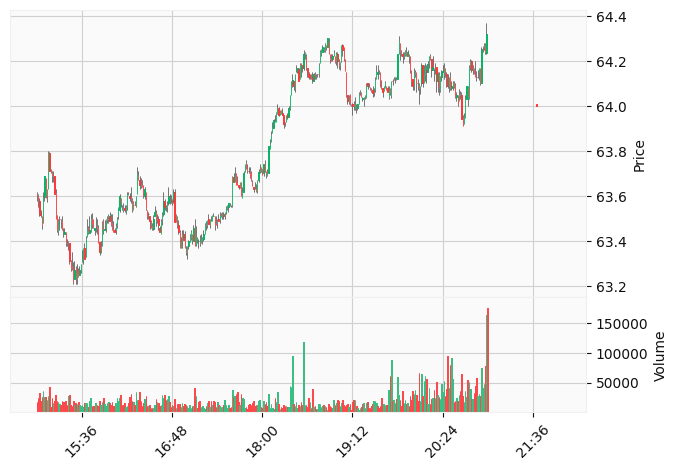

In [10]:
mpf.plot(year_df.loc['2019-01-02 15:00':'2019-01-02 22:00',:], type='candle', volume=True, show_nontrading=True, style='yahoo')


# 2. Feature Engineering

In [11]:
year_df.head()

,volume,open,close,high,low,num_trades
timestamp,,,,,,
2019-01-02 12:17:00,300.0,63.67,63.68,63.68,63.67,4.0
2019-01-02 12:21:00,487.0,63.50,63.53,63.53,63.50,5.0
2019-01-02 12:22:00,1949.0,63.50,63.50,63.50,63.47,8.0
2019-01-02 12:31:00,203.0,63.52,63.52,63.52,63.52,3.0
2019-01-02 12:34:00,238.0,63.55,63.55,63.55,63.55,4.0


Compute the labels we're training for:

In [12]:
WINDOW_SIZE = 5  # looking 5 bars into the future

PCT_WINDOWS = [0.05, 0.1, 0.15, 0.2, 0.25]
LABELS = (['down_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS, reverse=True)] +
          ['up_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS)])

In [14]:
tqdm.pandas()  # graphical load bar

def compute_label(formatted_df, pct, direction, row):
    window = formatted_df[formatted_df.index > row.name].iloc[:WINDOW_SIZE]
    if len(window) == WINDOW_SIZE:
        if direction == 'up':
            return int(max(window['high']) >= row['close']*(1+(pct/100)))
        return int(min(window['low']) <= row['close']*(1-(pct/100)))
    return None

/Users/john/.local/share/virtualenvs/pbc-AS_-2Y6Z/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [15]:
if RUNTIME == 'local':
    FORMATTED_DF_DIR = '.data/formatted_df.parquet.gzip'
elif RUNTIME == 'colab':
    FORMATTED_DF_DIR = '/content/drive/My Drive/pbc/formatted_df.parquet.gzip'

try:
    formatted_df = pd.read_parquet(FORMATTED_DF_DIR)
except FileNotFoundError as e:
    # sanitize
    formatted_df = (year_df
        .sort_index(inplace=False)
        .drop_duplicates()
        # filter out times before 9:30 and after 4:00
        .between_time('13:30','20:00')
        .dropna()
    )
    
    # compute labels
    for pct in [0.05, 0.1, 0.15, 0.2, 0.25]:
        formatted_df['up_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'up'), axis=1)
        formatted_df['down_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'down'), axis=1)
    
    # compute features
    formatted_df['open_close_pct_delta'] = (formatted_df['close'] - formatted_df['open'])/formatted_df['open']
    formatted_df['vol'] = (formatted_df['high'] - formatted_df['low'])/formatted_df['open']
    formatted_df['{}min_vol_std'.format(WINDOW_SIZE)] = formatted_df['vol'].rolling(5).std()
    formatted_df['{}min_ocd_std'.format(WINDOW_SIZE)] = formatted_df['open_close_pct_delta'].rolling(5).std()
    scaler = MinMaxScaler()
    formatted_df[['scaled_volume']] = scaler.fit_transform(formatted_df[['volume']])
    
    
    formatted_df = formatted_df.dropna()
    formatted_df.to_parquet(FORMATTED_DF_DIR, compression='gzip')


In [16]:
#mpf.plot(formatted_df, type='candle', volume=True, show_nontrading=True, style='yahoo')

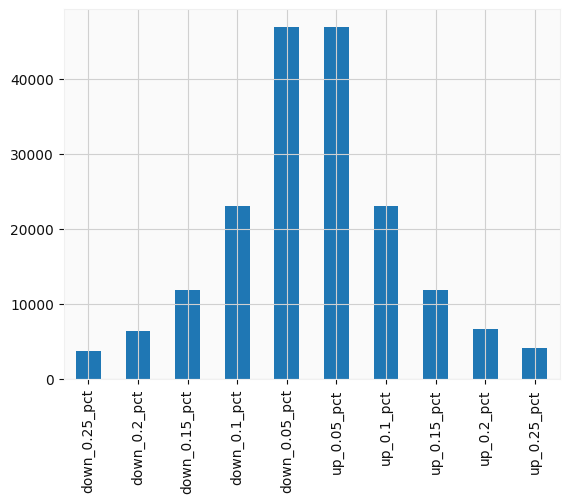

In [17]:
def plot_label_frequency():
    formatted_df[LABELS].sum().plot(kind='bar')
plot_label_frequency()

# 3. Build the Model

In [18]:
FEATURES = ['open_close_pct_delta', 'vol', '5min_vol_std', '5min_ocd_std', 'scaled_volume']

X_all = formatted_df[FEATURES]
twenty_pct = (len(X_all)//5)
X_train, X_val, X_test = X_all[:twenty_pct*3], X_all[twenty_pct*3:twenty_pct*4], X_all[twenty_pct*4:]
y_all = formatted_df[LABELS]
y_train, y_val, y_test = y_all[:twenty_pct*3], y_all[twenty_pct*3:twenty_pct*4], y_all[twenty_pct*4:]


In [19]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=20)

Epoch 1/50
2811/2811 [==============================] - 3s 985us/step - loss: 0.4006 - accuracy: 0.3127 - val_loss: 0.4217 - val_accuracy: 0.3406
Epoch 2/50
2811/2811 [==============================] - 3s 1ms/step - loss: 0.3815 - accuracy: 0.3127 - val_loss: 0.4184 - val_accuracy: 0.2738
Epoch 3/50
2811/2811 [==============================] - 3s 976us/step - loss: 0.3760 - accuracy: 0.3135 - val_loss: 0.4300 - val_accuracy: 0.2543
Epoch 4/50
2811/2811 [==============================] - 3s 942us/step - loss: 0.3727 - accuracy: 0.3087 - val_loss: 0.4140 - val_accuracy: 0.3349
Epoch 5/50
2811/2811 [==============================] - 3s 948us/step - loss: 0.3717 - accuracy: 0.3101 - val_loss: 0.4000 - val_accuracy: 0.3274
Epoch 6/50
2811/2811 [==============================] - 3s 968us/step - loss: 0.3714 - accuracy: 0.3119 - val_loss: 0.4016 - val_accuracy: 0.3331
Epoch 7/50
2811/2811 [==============================] - 3s 964us/step - loss: 0.3713 - accuracy: 0.3104 - val_loss: 0.4063 - v

In [20]:
def test_predictions(model):
    test_df = X_test.copy()
    predictions = []
    for idx, row in test_df.iterrows():
        predictions.append(model.predict(np.reshape(row.to_numpy(), (-1, len(FEATURES))))[0])

    return test_df.assign(**{label: [pred[idx] for pred in predictions]
                             for idx, label in enumerate(LABELS)})

display(test_predictions(model))

,open_close_pct_delta,vol,5min_vol_std,5min_ocd_std,scaled_volume,down_0.25_pct,down_0.2_pct,down_0.15_pct,down_0.1_pct,down_0.05_pct,up_0.05_pct,up_0.1_pct,up_0.15_pct,up_0.2_pct,up_0.25_pct
timestamp,,,,,,,,,,,,,,,
2019-10-15 14:37:00,0.000231,0.000461,0.000139,0.000243,0.003060,0.004815,0.011863,0.033764,0.110801,0.357050,0.352281,0.112882,0.032872,0.013193,0.005878
2019-10-15 14:38:00,-0.000696,0.000938,0.000198,0.000412,0.002121,0.012534,0.029129,0.072109,0.191828,0.470829,0.476153,0.202074,0.076320,0.032752,0.014791
2019-10-15 14:39:00,-0.000197,0.000922,0.000234,0.000331,0.005704,0.016972,0.036691,0.084571,0.209259,0.483321,0.486809,0.220237,0.089723,0.040802,0.019560
2019-10-15 14:40:00,0.000866,0.000924,0.000209,0.000587,0.005392,0.027537,0.057118,0.121692,0.268508,0.541919,0.547217,0.281246,0.130824,0.062167,0.030255
2019-10-15 14:41:00,-0.000231,0.000923,0.000208,0.000587,0.013734,0.055391,0.095968,0.171976,0.320487,0.570500,0.572256,0.337805,0.186950,0.103355,0.058615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:51:00,0.000023,0.000057,0.000083,0.000053,0.000536,0.001111,0.003362,0.012498,0.057077,0.266314,0.259050,0.058949,0.012018,0.004122,0.001589
2019-12-31 19:52:00,0.000000,0.000114,0.000083,0.000053,0.001050,0.001295,0.003799,0.013658,0.060177,0.271203,0.263696,0.061881,0.013099,0.004593,0.001814
2019-12-31 19:53:00,0.000171,0.000228,0.000083,0.000084,0.003101,0.002073,0.005609,0.018357,0.072569,0.292485,0.284814,0.074119,0.017548,0.006531,0.002742


# 4. Tuning

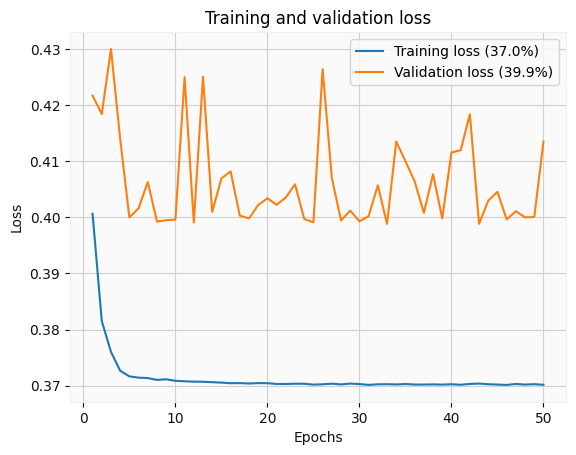

In [21]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss ({:.3}%)'.format(min(loss)*100))
    plt.plot(epochs, val_loss, label='Validation loss ({:.3}%)'.format(min(val_loss)*100))
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_loss(history)

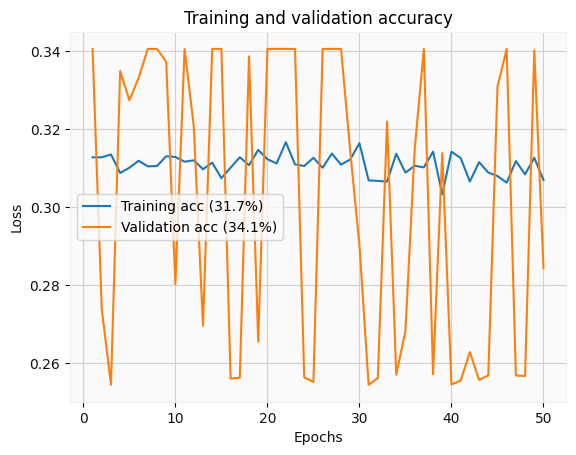

In [22]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, label='Training acc ({:.3}%)'.format(max(acc)*100))
    plt.plot(epochs, val_acc, label='Validation acc ({:.3}%)'.format(max(val_acc)*100))
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_accuracy(history)

# 5. Analysis